In [3]:
import sys
sys.path.append('../../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [5]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                  image                   id  \
2323  ../../data/Train/CameraRGB/episode_0004_000084...  episode_0004_000084   
517   ../../data/Train/CameraRGB/episode_0010_000081...  episode_0010_000081   
1701  ../../data/Train/CameraRGB/episode_0007_000168...  episode_0007_000168   
4519  ../../data/Train/CameraRGB/episode_0007_000050...  episode_0007_000050   
1187  ../../data/Train/CameraRGB/episode_0005_000235...  episode_0005_000235   

                                                  label  
2323  ../../data/Train/CameraSeg/episode_0004_000084...  
517   ../../data/Train/CameraSeg/episode_0010_000081...  
1701  ../../data/Train/CameraSeg/episode_0007_000168...  
4519  ../../data/Train/CameraSeg/episode_0007_000050...  
1187  ../../data/Train/CameraSeg/episode_0005_000235...  


In [6]:
from models.fcn8 import model_fcn8

model = model_fcn8(3, image_shape=(320, 416, 3), keep_prob=0.5)
model.summary()

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 208, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [8]:
from gen.generators import gen_func_patch, gen_func, preprocess_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)


rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function = preprocess_label, **img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_label)

BATCH_SIZE=32
model_dir = '../../saved_models/fcn8/fcn8_v2/'

train_gen = gen_func_patch(train_df, rgb_gen, lab_gen, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)
valid_gen = gen_func(valid_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)


In [11]:
from train import weighted_categorical_crossentropy
from keras.utils.training_utils import multi_gpu_model

weights = np.array([70, 20, 10])

gpus = 2

model_gpu = multi_gpu_model(model, gpus)
model_gpu.load_weights('../../saved_models/fcn8/fcn8_with_patches/model.hdf5')
model_gpu.compile(loss=weighted_categorical_crossentropy(weights),
              optimizer='adam',
              metrics=['accuracy'])


In [13]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=100,
                  gpus = 2)

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Reinserting dataframe: 500 images
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting datafra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



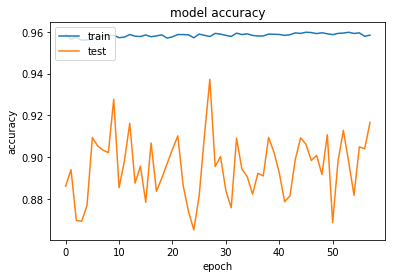

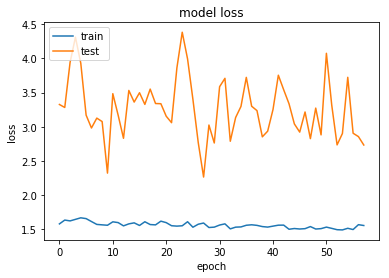

In [14]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('../../saved_models/fcn8/fcn8_v2/model_saved.h5')

In [ ]:
#valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE * gpus)
#test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE * gpus)